## NuScenes 3D to 2D Projection (LiDAR to Camera)

In [82]:
# Setup and Imports
# This cell installs the nuScenes devkit if you don't have it, 
! pip install nuscenes-devkit
# Run this outside of your Jupyter notebook or in a new cell
! pip install --upgrade nuscenes-devkit pyquaternion

In [83]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pyquaternion import Quaternion

# Core nuScenes imports
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud, Box
from nuscenes.utils.geometry_utils import transform_matrix

# --- Configuration and Initialization ---

In [84]:
# ⚠️ UPDATE THESE PATHS ⚠️
# Set the root directory for your nuScenes dataset
NUSCENES_ROOT = "/data/nuscenes" 
VERSION = "v1.0-trainval"  # Use "v1.0-trainval" for the full dataset

# Define the sensor channels to use
CAM_CHANNEL = "CAM_FRONT"
LIDAR_CHANNEL = "LIDAR_TOP"

# Initialize the nuScenes object
# Set verbose=False if you want a cleaner output
print(f"Initializing NuScenes dataset (version: {VERSION})...")
nusc = NuScenes(version=VERSION, dataroot=NUSCENES_ROOT, verbose=False)
print("Initialization complete.")

Initializing NuScenes dataset (version: v1.0-trainval)...


Initialization complete.


# --- Sample Selection and Data Loading ---

In [85]:
# Pick a sample. Use an index (e.g., 10) or look up a specific token.
sample_index = 10
sample = nusc.sample[sample_index]

print(f"Working with sample index: {sample_index}")

# Get the sample data tokens for the camera and lidar
lidar_token = sample["data"][LIDAR_CHANNEL]
cam_token = sample["data"][CAM_CHANNEL]

# Load the metadata for the sensor readings
lidar_data = nusc.get("sample_data", lidar_token)
cam_data = nusc.get("sample_data", cam_token)

# Load calibration records for both sensors
lidar_cs = nusc.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])
cam_cs = nusc.get("calibrated_sensor", cam_data["calibrated_sensor_token"])

# Load the actual camera image and Lidar point cloud
img_path = nusc.get_sample_data_path(cam_token)
image = cv2.imread(img_path)
# Convert BGR (OpenCV default) to RGB for Matplotlib display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load LIDAR points
pc = LidarPointCloud.from_file(nusc.get_sample_data_path(lidar_token))

print(f"Loaded image from: {img_path}")
print(f"LiDAR points shape: {pc.points.shape}")

Working with sample index: 10
Loaded image from: /data/nuscenes/samples/CAM_FRONT/n015-2018-07-18-11-07-57+0800__CAM_FRONT__1531883535412467.jpg
LiDAR points shape: (4, 34688)


# --- Coordinate Transformation ---

In [86]:
# --- Coordinate Transformation ---

# Goal: Transform points from (LiDAR Sensor) -> (Ego/Vehicle) -> (Camera Sensor)

# 1. Transform LiDAR Sensor Frame to Ego Vehicle Frame (Extrinsics)
# This uses the LiDAR's calibrated_sensor record (translation and rotation)
lidar_to_ego = transform_matrix(
    lidar_cs["translation"], 
    Quaternion(lidar_cs["rotation"])
)
pc.transform(lidar_to_ego)
print("Step 1: LiDAR -> Ego complete.")
print(lidar_to_ego)
# 2. Transform Ego Vehicle Frame to Camera Sensor Frame (Inverse Extrinsics)
# We need the inverse transformation because we are transforming points 
# FROM ego frame TO camera frame.
ego_to_cam = transform_matrix(
    cam_cs["translation"], 
    Quaternion(cam_cs["rotation"]), 
    inverse=True
)
pc.transform(ego_to_cam)
print("Step 2: Ego -> Camera complete.")
print(ego_to_cam)

Step 1: LiDAR -> Ego complete.
[[ 0.00203327  0.99970406  0.02424172  0.943713  ]
 [-0.99998053  0.00217566 -0.00584864  0.        ]
 [-0.00589965 -0.02422936  0.99968902  1.84023   ]
 [ 0.          0.          0.          1.        ]]
Step 2: Ego -> Camera complete.
[[ 5.68477868e-03 -9.99983517e-01  8.05071338e-04  5.06031940e-03]
 [-5.63666773e-03 -8.37115272e-04 -9.99983763e-01  1.52053325e+00]
 [ 9.99967955e-01  5.68014846e-03 -5.64133364e-03 -1.69230345e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


# --- Projection and Visualization ---

Step 3: Projected 12294 points onto the image plane.


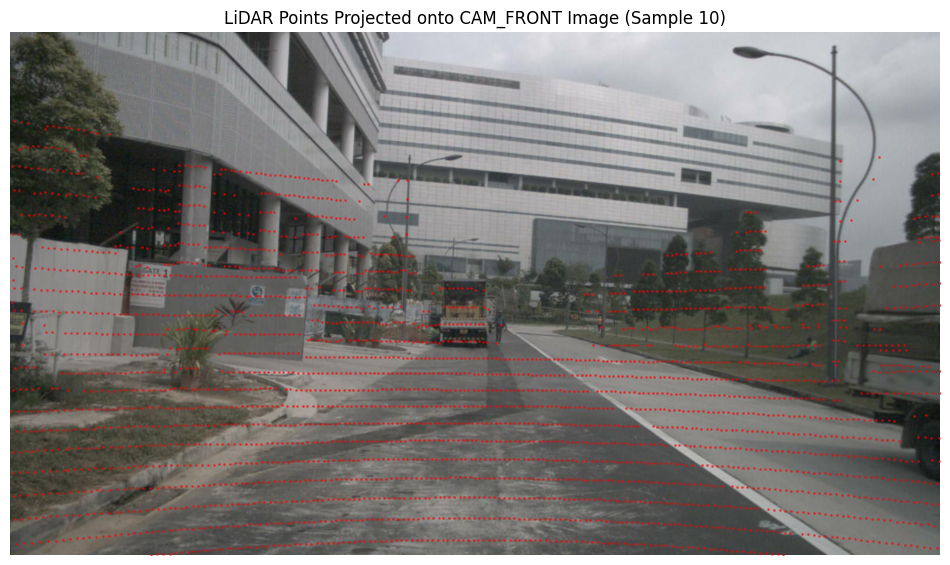

In [87]:
# 3. Project 3D points in Camera Frame to 2D Image Plane (Intrinsics)
intrinsic = np.array(cam_cs["camera_intrinsic"])
points_3d_cam = pc.points[:3, :] # Take only the x, y, z coordinates

# Filter points that are behind the camera (z > 0 in camera frame)
# This prevents division by zero and projection artifacts.
points_in_front = points_3d_cam[:, points_3d_cam[2, :] > 0]

# Perform perspective projection: P_2D = K @ P_3D
proj_points = intrinsic @ points_in_front
proj_points = proj_points[:2] / proj_points[2] # Normalize by depth (z)

# Convert to integers for plotting
proj_points = proj_points.astype(int)

print(f"Step 3: Projected {proj_points.shape[1]} points onto the image plane.")

# 4. Plot the overlay
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)

# Plot the projected points
# Filter points to be within the image bounds for a cleaner plot
H, W, _ = image_rgb.shape
valid_pts = (proj_points[0] > 0) & (proj_points[0] < W) & \
            (proj_points[1] > 0) & (proj_points[1] < H)

plt.scatter(
    proj_points[0, valid_pts], 
    proj_points[1, valid_pts], 
    s=1,  # size of the dot
    c='red', 
    alpha=0.5 # transparency
)
plt.title(f"LiDAR Points Projected onto {CAM_CHANNEL} Image (Sample {sample_index})")
plt.axis('off')
plt.show()

In [88]:
# --- Sample Selection and Data Loading for bounding box in image---

# Pick a sample
sample_index = 10
sample = nusc.sample[sample_index]

print(f"Working with sample index: {sample_index}")

# Get the sample data tokens and records
lidar_token = sample["data"][LIDAR_CHANNEL]
cam_token = sample["data"][CAM_CHANNEL]

lidar_data = nusc.get("sample_data", lidar_token)
cam_data = nusc.get("sample_data", cam_token)

# Load calibration records
lidar_cs = nusc.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])
cam_cs = nusc.get("calibrated_sensor", cam_data["calibrated_sensor_token"])

# Load image and Lidar points
img_path = nusc.get_sample_data_path(cam_token)
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pc = LidarPointCloud.from_file(nusc.get_sample_data_path(lidar_token))

# Get Ego Poses for both sensor readings
lidar_ego_pose = nusc.get("ego_pose", lidar_data["ego_pose_token"])
cam_ego_pose = nusc.get("ego_pose", cam_data["ego_pose_token"])

# Get all 3D annotations (bounding boxes) for this sample
ann_tokens = sample["anns"]
print(f"Loaded {len(ann_tokens)} annotations.")

Working with sample index: 10
Loaded 15 annotations.


In [89]:
# --- Define Transformation Matrices (LiDAR to Camera) ---

# 1. LiDAR Sensor to Ego (Extrinsics) at Lidar time
lidar_to_ego_extrinsics = transform_matrix(
    lidar_cs["translation"], 
    Quaternion(lidar_cs["rotation"])
)

# 2. Ego at Lidar time to Global Map Frame (Ego Pose at Lidar time)
lidar_ego_to_global = transform_matrix(
    lidar_ego_pose["translation"], 
    Quaternion(lidar_ego_pose["rotation"])
)

# 3. Global Map Frame to Ego at Camera time (Inverse Ego Pose at Camera time)
# (T_ego_cam_to_global)^-1
global_to_cam_ego = np.linalg.inv(
    transform_matrix(
        cam_ego_pose["translation"], 
        Quaternion(cam_ego_pose["rotation"])
    )
)

# 4. Ego to Camera Sensor (Inverse Extrinsics) at Camera time
# (T_ego_to_camera_extrinsics)^-1
ego_to_cam_extrinsics = np.linalg.inv(
    transform_matrix(
        cam_cs["translation"], 
        Quaternion(cam_cs["rotation"])
    )
)

# 5. Full transformation: LiDAR -> Ego (LiDAR) -> Global -> Ego (Cam) -> Camera
# Note: The original Lidar script only handled steps 1 and 4 (if data was from same keyframe).
# We must include the global frame transformation for annotations and cross-timestamp alignment.
# The full T_Lidar_to_Camera matrix is: 
# T_cam_to_ego * T_global_to_cam_ego * T_lidar_ego_to_global * T_lidar_to_ego_extrinsics
T_lidar_to_camera = ego_to_cam_extrinsics @ global_to_cam_ego @ lidar_ego_to_global @ lidar_to_ego_extrinsics

# Camera intrinsic matrix (K)
intrinsic = np.array(cam_cs["camera_intrinsic"])

In [90]:
from pyquaternion import Quaternion
import numpy as np
# --- HELPER FUNCTION FOR THE BOX FIX ---
def matrix_to_quaternion_translation(matrix):
    """Converts a 4x4 matrix to a Quaternion and translation vector."""
    translation = matrix[:3, 3]
    rotation_matrix = matrix[:3, :3]
    rotation = Quaternion(matrix=rotation_matrix)
    return rotation, translation

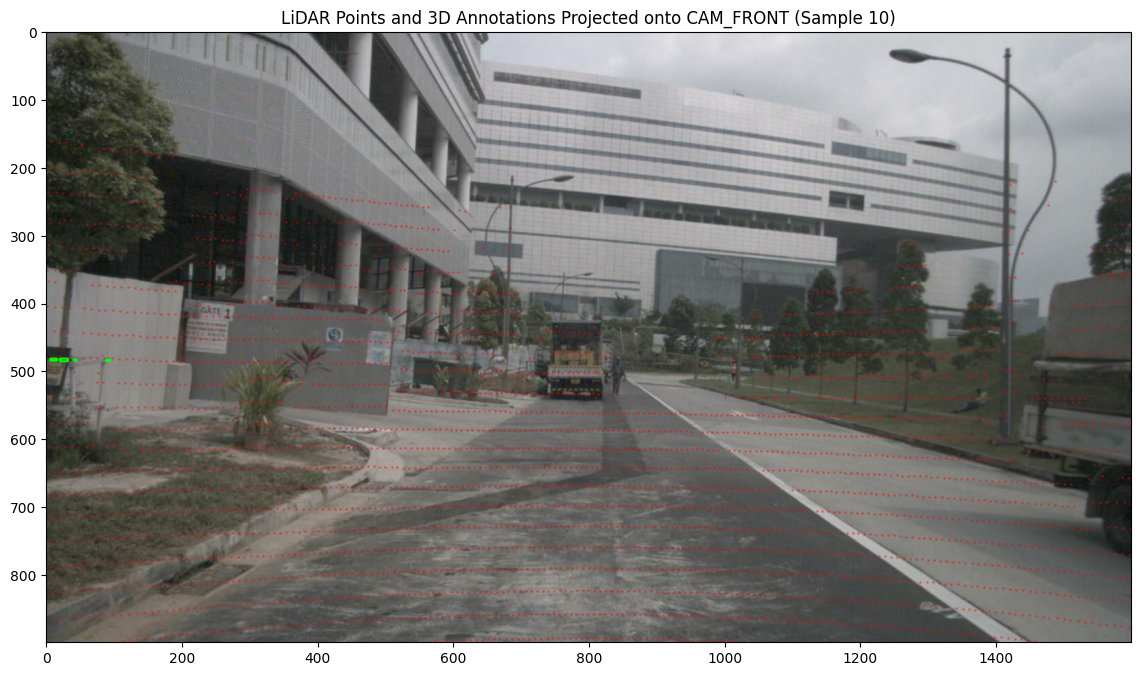

In [91]:
# --- Lidar Point Projection ---
pc_full = LidarPointCloud.from_file(nusc.get_sample_data_path(lidar_token))
pc_full.transform(T_lidar_to_camera)

points_3d_cam = pc_full.points[:3, :]
points_in_front = points_3d_cam[:, points_3d_cam[2, :] > 0]

proj_points = intrinsic @ points_in_front
proj_points = proj_points[:2] / proj_points[2]
proj_points = proj_points.astype(int)

# --- Bounding Box Projection (The logic is now correct) ---
image_with_boxes = image_rgb.copy()
box_color = (0, 255, 0)

# Decompose the two necessary transformation matrices
R_lidar_to_global, t_lidar_to_global = matrix_to_quaternion_translation(lidar_ego_to_global)
T_Global_to_Camera = ego_to_cam_extrinsics @ global_to_cam_ego
R_global_to_cam, t_global_to_cam = matrix_to_quaternion_translation(T_Global_to_Camera)

corners_map = [
    (0, 1), (1, 2), (2, 3), (3, 0), (4, 5), (5, 6), (6, 7), (7, 4), (0, 4), (1, 5), (2, 6), (3, 7)
]

for ann_token in ann_tokens:
    box = nusc.get_box(ann_token)
    
    # Lidar_Top -> Global
    box.rotate(R_lidar_to_global)
    box.translate(t_lidar_to_global)
    
    # Global -> Camera Sensor
    box.rotate(R_global_to_cam)
    box.translate(t_global_to_cam)

    corners_3d_cam = box.corners()
    
    # Projection
    if np.any(corners_3d_cam[2, :] > 0):
        corners_2d_hom = intrinsic @ corners_3d_cam
        corners_2d = corners_2d_hom[:2, :] / corners_2d_hom[2, :]
        corners_2d = corners_2d.astype(int)
        
        # Drawing
        H, W, _ = image.shape
        for i, j in corners_map:
            pt1 = (corners_2d[0, i], corners_2d[1, i])
            pt2 = (corners_2d[0, j], corners_2d[1, j])
            
            if (0 < pt1[0] < W and 0 < pt1[1] < H) or (0 < pt2[0] < W and 0 < pt2[1] < H):
                cv2.line(image_with_boxes, pt1, pt2, box_color, 2)


# --- Final Plot ---
plt.figure(figsize=(14, 8))
plt.imshow(image_with_boxes)

# Overlay Lidar points
H, W, _ = image_rgb.shape
valid_pts = (proj_points[0] > 0) & (proj_points[0] < W) & (proj_points[1] > 0) & (proj_points[1] < H)

plt.scatter(
    proj_points[0, valid_pts], 
    proj_points[1, valid_pts], 
    s=1, 
    c='red', 
    alpha=0.3
)
plt.title(f"LiDAR Points and 3D Annotations Projected onto {CAM_CHANNEL} (Sample {10})")
plt.axis('on')
plt.show()

In [92]:
# Assuming 'nusc' is your initialized NuScenes object
# Assuming 'ann_token' is the string token of the object's annotation

ann_record = nusc.get("sample_annotation", ann_token)

# The 3D bounding box is defined by three primary fields:
# 1. translation: The center point (x, y, z)
# 2. size: The dimensions (width, length, height)
# 3. rotation: The orientation (as a Quaternion)

In [93]:
# The translation is a list: [x, y, z]
center_point_list = ann_record["translation"]

x = center_point_list[0]
y = center_point_list[1]
z = center_point_list[2]

# The center point is typically in the global map coordinate frame.
print(f"Object Center Point (Global Coordinates): x={x:.2f}, y={y:.2f}, z={z:.2f}")

Object Center Point (Global Coordinates): x=970.11, y=645.15, z=1.01


# --- Projecting Object Center Points ---

In [94]:
# Assuming cam_data is the sample_data for the camera
cam_ego_pose_record = nusc.get("ego_pose", cam_data["ego_pose_token"])
# 1. T_Ego_to_Global
T_Ego_to_Global = transform_matrix(
    cam_ego_pose_record["translation"], 
    Quaternion(cam_ego_pose_record["rotation"])
)
# 2. T_Global_to_Ego (Inverse)
T_Global_to_Ego = np.linalg.inv(T_Ego_to_Global)


In [104]:
import numpy as np
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import Box
from pyquaternion import Quaternion
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os

# --- Configuration and Initialization ---

# NOTE: Replace this path with your actual nuScenes data root
DATAROOT = '/data/nuscenes' 
if not os.path.exists(DATAROOT):
    print("Warning: DATAROOT not found. Using dummy data for projection logic demonstration.")
    # Exit or handle dummy data gracefully if necessary
    # For this example, we'll assume the environment is set up correctly for the projection logic
    # but the image file might be missing. The projection steps are still valid.
    pass

# Initialize nuScenes object
# Using 'v1.0-mini' is generally safer for local testing if you don't have the full dataset
nusc = NuScenes(version='v1.0-trainval', dataroot=DATAROOT)


Loading NuScenes tables for version v1.0-trainval...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
34149 lidarseg,
Done loading in 69.290 seconds.
Reverse indexing ...
Done reverse indexing in 9.4 seconds.


In [107]:
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
import numpy as np
# ... (nusc, sample, sd_token, etc., are assumed initialized)

# Get the LiDAR data record for the current sample
lidar_token = sample['data']['LIDAR_TOP']
lidar_record = nusc.get('sample_data', lidar_token)
lidar_filename = os.path.join(nusc.dataroot, lidar_record['filename'])

# Load the point cloud
pc = LidarPointCloud.from_file(lidar_filename)

# Apply sensor-to-ego and ego-to-global transformations
# This transforms the point cloud from the LIDAR_TOP frame to the GLOBAL frame.
nusc.map_pointcloud_to_global(pc, lidar_token)

# The point cloud 'pc.points' is now a 4xN NumPy array (x, y, z, intensity)
# where x, y, z are in global coordinates.

AttributeError: 'NuScenes' object has no attribute 'map_pointcloud_to_global'

In [106]:
# --- Define Target Sample ---

# Sample token (a specific keyframe in the dataset)
sample_token = 'e93e98b63d3b40209056d129dc53ceee' 
camera_channel = 'CAM_FRONT' 

# Get records
sample = nusc.get('sample', sample_token)
sd_token = sample['data'][camera_channel]
sd_record = nusc.get('sample_data', sd_token)
image_filename = os.path.join(nusc.dataroot, sd_record['filename'])

# --- Projection and Drawing Logic ---

# 1. Load the image using Pillow (preferred for simple drawing)
try:
    img_pil = Image.open(image_filename)
except FileNotFoundError:
    print(f"Error: Image file not found at {image_filename}.")
    # Create a placeholder image if the data is missing, to show the drawing logic
    img_pil = Image.new('RGB', (1600, 900), color = 'gray')
    print("Using a placeholder image for visualization.")

draw = ImageDraw.Draw(img_pil)

# Drawing parameters
RADIUS = 15
CENTER_COLOR = 'yellow' 

print(f"\nProcessing annotations for image: {sd_record['token']}")

# 2. Iterate through annotations and project center points
for ann_token in sample['anns']:
    annotation = nusc.get('sample_annotation', ann_token)
    
    # 2.1. Get the 3D center point in GLOBAL coordinates
    point_in_global = np.array(annotation['translation']) 
    
    # 2.2. Project the GLOBAL 3D point to the 2D image plane
    # The 'nusc.box_to_sensor' logic for a single point is handled by manually projecting
    # The nuScenes devkit helper for this task is often found in internal utilities, 
    # but the low-level logic involves accessing the pose and calibrated sensor records:
    
    # Get the coordinate records
    cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    pose_record = nusc.get('ego_pose', sd_record['ego_pose_token'])
    
    # Use the Box class's coordinate transformations for simplicity, 
    # though only the center is needed.
    my_box = Box(
        annotation['translation'],
        annotation['size'],
        Quaternion(annotation['rotation']),
        name=annotation['category_name']
    )
    
    # Transform the 3D center from GLOBAL to CAMERA frame
    my_box.translate(-np.array(pose_record['translation']))
    my_box.rotate(Quaternion(pose_record['rotation']).inverse)
    my_box.translate(-np.array(cs_record['translation']))
    my_box.rotate(Quaternion(cs_record['rotation']).inverse)

    point_in_cam = my_box.center # This is now the 3D point in the camera frame
    
    # Check if the point is in front of the camera (depth > 0)
    if point_in_cam[2] > 0.1: # z > 0 (or a small epsilon to be safe)
        # 2.3. Project to 2D using intrinsics
        # K is the camera intrinsic matrix
        K = np.array(cs_record['camera_intrinsic'])
        
        # Homogeneous projection: P_img_h = K * P_cam
        # We only need the x, y, z for the center point
        point_cam_homo = np.append(point_in_cam[:3], 1)
        projected_homo = K @ point_in_cam[:3]
        
        # Perspective division: u = u_h / w_h, v = v_h / w_h
        center_u = int(projected_homo[0] / projected_homo[2])
        center_v = int(projected_homo[1] / projected_homo[2])
        
        print(f"Projected {annotation['category_name']} center to: ({center_u}, {center_v})")
        
        # 3. Draw the point (Pillow)
        # Bounding box for the circle: (x0, y0, x1, y1)
        x0, y0 = center_u - RADIUS, center_v - RADIUS
        x1, y1 = center_u + RADIUS, center_v + RADIUS

        draw.ellipse(
            xy=((x0, y0), (x1, y1)),
            fill=CENTER_COLOR
        )
    else:
        print(f"Skipping {annotation['category_name']}: Object is behind the camera (z={point_in_cam[2]:.2f}).")

    # USING LIDAR
    # Transform the box from global to its own local frame for easy point filtering
    my_box.translate(-my_box.center)
    my_box.rotate(my_box.rotation.inverse)
    box_corners = my_box.corners() # 3x8 matrix of local corner coordinates

    # Transform point cloud from global to the box's local frame
    pc.translate(-np.array(annotation['translation']))
    pc.rotate(Quaternion(annotation['rotation']).inverse)

    # Filter points: check if x, y, and z are within the bounds of the box's local frame
    # The box extents are half the size (annotation['size'][i] / 2)
    box_size = np.array(annotation['size']) / 2.0
    points_in_box = np.where(
        (pc.points[0, :] < box_size[0]) & (pc.points[0, :] > -box_size[0]) &
        (pc.points[1, :] < box_size[1]) & (pc.points[1, :] > -box_size[1]) &
        (pc.points[2, :] < box_size[2]) & (pc.points[2, :] > -box_size[2])
    )[0]

    # Extract the filtered points (still in the box's local frame)
    filtered_pc_local = pc.points[:3, points_in_box]
    
if filtered_pc_local.shape[1] > 0:
    # Calculate the squared 2D Euclidean distance (x^2 + y^2) for each point
    # We use the X and Y coordinates (indices 0 and 1) for ground distance
    distances_sq = filtered_pc_local[0, :]**2 + filtered_pc_local[1, :]**2

    # Find the maximum distance
    max_distance_sq = np.max(distances_sq)
    max_distance_to_center = np.sqrt(max_distance_sq)   
    print(f"-> Calculated Edge Distance from Center (2D): {max_distance_to_center:.2f} meters")
else:
    print("-> No LiDAR points found inside this bounding box.")
    max_distance_to_center = 0.0


# Create a new point cloud object from the filtered local points
pc_to_project = LidarPointCloud(filtered_pc_local)

# Reverse transform: Box Local -> Global
# The order is crucial: apply inverse of Box rotation, then inverse of Box translation
pc_to_project.rotate(Quaternion(annotation['rotation']))
pc_to_project.translate(np.array(annotation['translation']))

# Now, project these points (currently in global coordinates) onto the image
# This requires the camera-specific transformations (handled in Step 3.2, which is complex)
# It's cleaner to use the nuScenes utility for projection if available.

# We'll use the logic similar to the 'render_pointcloud_2d' from the devkit:
points_global = pc_to_project.points[:3, :] # 3xN matrix
num_points = points_global.shape[1]

# Get camera calibration and pose (same as the center point projection)
cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
pose_record = nusc.get('ego_pose', sd_record['ego_pose_token'])
K = np.array(cs_record['camera_intrinsic'])

# Transformation chain matrices
T_global_to_ego = np.linalg.inv(nusc.get_transform_matrix(pose_record['translation'], Quaternion(pose_record['rotation'])))
T_ego_to_cam = nusc.get_transform_matrix(cs_record['translation'], Quaternion(cs_record['rotation'])).T

# 3D points in the camera frame
points_cam_homo = T_ego_to_cam @ T_global_to_ego @ np.vstack((points_global, np.ones(num_points)))
points_cam = points_cam_homo[:3, :]

# Filter out points behind the camera (z > 0 check)
valid_indices = points_cam[2, :] > 0.1
points_cam_valid = points_cam[:, valid_indices]

# Project to 2D
points_2d_homo = K @ points_cam_valid
points_2d = points_2d_homo[:2, :] / points_2d_homo[2, :]

# Final pixel coordinates (u, v)
points_u = points_2d[0, :].astype(int)
points_v = points_2d[1, :].astype(int)

# --- Drawing ---
# img_pil and draw object are assumed to be open from the previous step
for u, v in zip(points_u, points_v):
    if 0 <= u < img_pil.width and 0 <= v < img_pil.height:
        # Draw a smaller dot for point cloud
        draw.ellipse((u - 3, v - 3, u + 3, v + 3), fill='yellow') 

# Display the image (as shown in the previous response)

# 4. Display the resulting image
plt.figure(figsize=(12, 8))
plt.imshow(img_pil)
plt.title(f"NuScenes Image with Annotated Center Points ({camera_channel})")
plt.axis('off')
plt.show()

# 5. Optional: Save the image
# img_pil.save("nuscenes_center_overlay.jpg")


Processing annotations for image: 020d7b4f858147558106c504f7f31bef
Skipping movable_object.trafficcone: Object is behind the camera (z=-1.91).


AttributeError: 'Box' object has no attribute 'rotation'